In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('D:\\financial_time_series\\bitcoin_price_history.csv', parse_dates=['startTime'])

data['startTime'] = pd.to_datetime(data['startTime'])
data.set_index('startTime', inplace=True)

data.sort_index(inplace=True)

def create_features(df):
    df['lag1'] = df['closePrice'].shift(1)
    df['lag2'] = df['closePrice'].shift(2)
    df['lag3'] = df['closePrice'].shift(3)
    df['rolling_mean'] = df['closePrice'].rolling(window=5).mean()
    df['rolling_std'] = df['closePrice'].rolling(window=5).std()
    df['volume_rolling_mean'] = df['volume'].rolling(window=5).mean()
    df['turnover_rolling_mean'] = df['turnover'].rolling(window=5).mean()

    df = df.dropna()

    return df

data = create_features(data)

In [3]:
X = data[['lag1', 'lag2', 'lag3', 'rolling_mean', 'rolling_std', 'volume_rolling_mean', 'turnover_rolling_mean']].values
y = data['closePrice'].values

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

def create_dataset(X, y, time_step=1):
    X_data, y_data = [], []
    for i in range(len(X) - time_step):
        X_data.append(X[i:(i + time_step), :])
        y_data.append(y[i + time_step, 0])
    return np.array(X_data), np.array(y_data)

time_step = 60  # 60 дней

X_all, y_all = create_dataset(X_scaled, y_scaled, time_step)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

In [4]:
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(units=50, return_sequences=False))
model.add(Dense(units=1))  # Для прогнозирования одной цены

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

D:\financial_time_series\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0314 - val_loss: 0.0022
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.8894e-04 - val_loss: 0.0021
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.5219e-04 - val_loss: 0.0020
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.1973e-04 - val_loss: 0.0023
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.7962e-04 - val_loss: 0.0020
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.2573e-04 - val_loss: 0.0022
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.5066e-04 - val_loss: 0.0020
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.7279e-04 - val_loss: 0.0019
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.3949e-04 - val_loss: 0.0019
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.8987e-04 - val_loss: 0.0019
Epoch 12/100
44/

In [6]:
y_pred = model.predict(X_test)

y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler_y.inverse_transform(y_pred)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [7]:
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE): 7869661.0869
Root Mean Squared Error (RMSE): 2805.2916


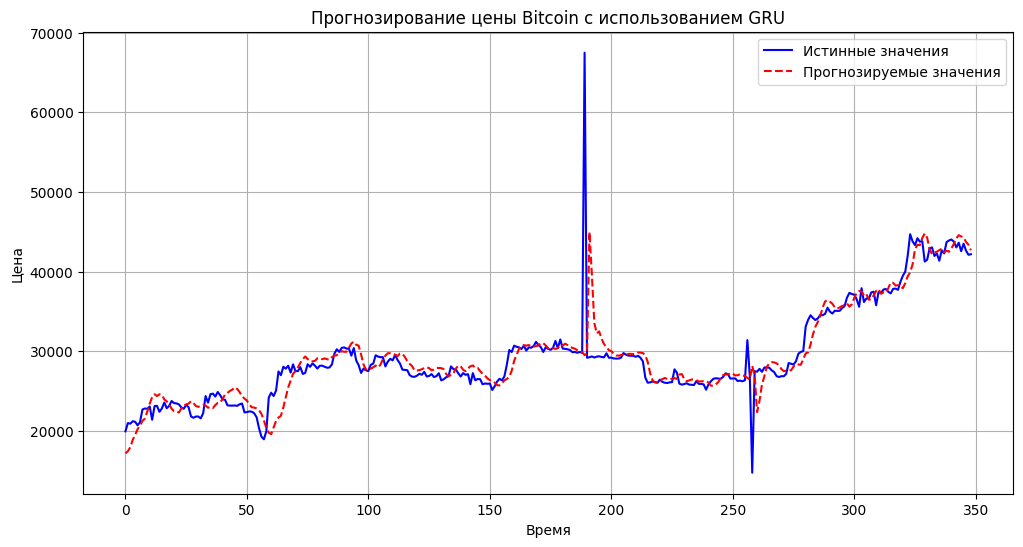

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, color='blue', label='Истинные значения')
plt.plot(y_pred_rescaled, color='red', label='Прогнозируемые значения', linestyle='--')
plt.title('Прогнозирование цены Bitcoin с использованием GRU')
plt.xlabel('Время')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

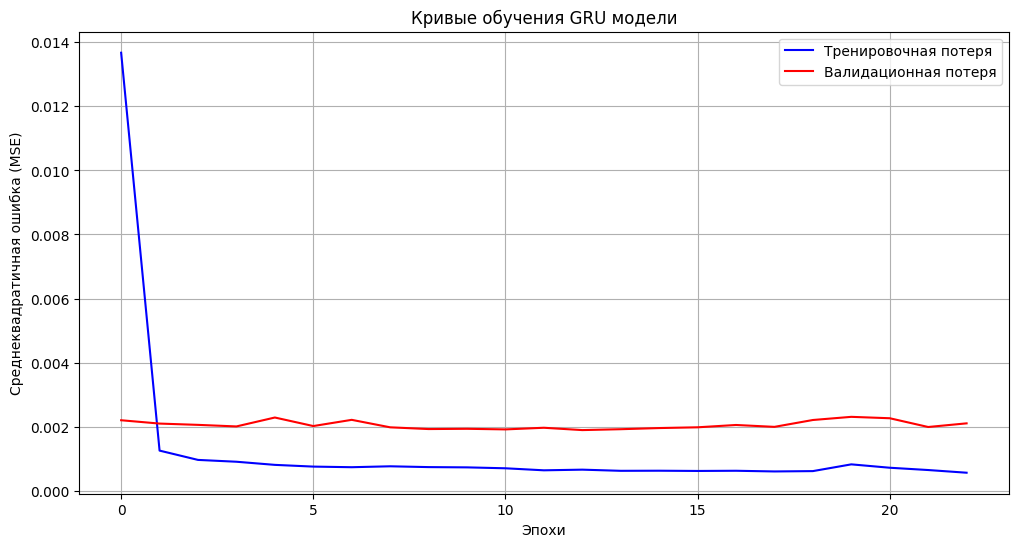

In [13]:
# 20. Визуализация кривых обучения (Training and Validation Loss)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], color='blue', label='Тренировочная потеря')
plt.plot(history.history['val_loss'], color='red', label='Валидационная потеря')
plt.title('Кривые обучения GRU модели')
plt.xlabel('Эпохи')
plt.ylabel('Среднеквадратичная ошибка (MSE)')
plt.legend()
plt.grid(True)
plt.show()